# USAD

## Environment

In [26]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [10]:
!git clone https://github.com/manigalati/usad

Cloning into 'usad'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 89 (delta 3), reused 2 (delta 0), pack-reused 78
Receiving objects: 100% (89/89), 2.82 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [1]:
%cd usad

[Errno 2] No such file or directory: 'usad'
/workspace/Automl/AutoEncoder/usad


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [3]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-858b82ed-2996-c38a-bccd-2b928a625f8d)


## EDA - Data Pre-Processing

### Download dataset

### Normal period

In [4]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

mkdir: cannot create directory ‘input’: File exists
zsh:1: no matches found: https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw
zsh:1: no matches found: https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7


In [5]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(495000, 51)

In [6]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [8]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Windows

### Attack

In [9]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(449919, 51)

In [10]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [11]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [12]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


In [13]:
window_size=12

In [14]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [15]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [16]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 10
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *.5 * windows_normal.shape[0])):]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(np.concatenate([windows_normal_test,windows_attack])).float().view(([windows_normal_test.shape[0]+windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [28]:
N_EPOCHS = 50

In [29]:
history = training(N_EPOCHS,model,train_loader,val_loader)

loss1 0.10155744850635529
loss1 0.038891054689884186
loss1 0.042803604155778885
loss1 0.03838491439819336
loss1 0.03257167711853981
loss1 0.03621838241815567
loss1 0.03591408580541611
loss1 0.033909086138010025
loss1 0.034029070287942886
loss1 0.039547864347696304
loss1 0.04990182816982269
loss1 0.04941960796713829
loss1 0.04800737649202347
loss1 0.0464165173470974
loss1 0.04459172487258911
loss1 0.04037521034479141
loss1 0.03681739419698715
loss1 0.03393245115876198
loss1 0.032940421253442764
loss1 0.034930139780044556
loss1 0.03716949373483658
loss1 0.037030450999736786
loss1 0.0328327901661396
loss1 0.030076080933213234
loss1 0.028953347355127335
loss1 0.020991159602999687
Epoch [0], val_loss1: 0.0282, val_loss2: 0.0289
loss1 0.09863145649433136
loss1 0.03578846901655197
loss1 0.038604896515607834
loss1 0.03860612213611603
loss1 0.039439842104911804
loss1 0.04070185124874115
loss1 0.03904329612851143
loss1 0.03651787340641022
loss1 0.03042973205447197
loss1 0.021123148500919342
loss

loss1 0.026763005182147026
loss1 0.03392958268523216
loss1 0.02980685792863369
loss1 0.028959505259990692
loss1 0.02801400050520897
loss1 0.024494318291544914
loss1 0.019561631605029106
loss1 0.012084519490599632
loss1 0.013813325203955173
loss1 0.01478137169033289
loss1 0.013879288919270039
loss1 0.01487553771585226
loss1 0.013592171482741833
loss1 0.012706732377409935
loss1 0.01307093258947134
loss1 0.013360325247049332
loss1 0.01474273856729269
loss1 0.01531890593469143
loss1 0.015101781114935875
loss1 0.012758503668010235
loss1 0.011724219657480717
loss1 0.011806309223175049
loss1 0.007114196661859751
Epoch [11], val_loss1: 0.0146, val_loss2: -0.0122
loss1 0.04766814410686493
loss1 0.026834746822714806
loss1 0.025546366348862648
loss1 0.02257153019309044
loss1 0.026939455419778824
loss1 0.02271132729947567
loss1 0.02279517985880375
loss1 0.02266084775328636
loss1 0.023753466084599495
loss1 0.02169826813042164
loss1 0.011947880499064922
loss1 0.013351188972592354
loss1 0.01366871036

loss1 0.011709111742675304
loss1 0.01014755666255951
loss1 0.012434960342943668
loss1 0.012171139940619469
loss1 0.017716998234391212
loss1 0.02256758324801922
loss1 0.009467769414186478
loss1 0.008501830510795116
loss1 0.008021236397325993
loss1 0.006376470904797316
loss1 0.005511391442269087
loss1 0.004152658395469189
loss1 0.0036938951816409826
loss1 0.0032443723175674677
loss1 0.0034239739179611206
loss1 0.00563938869163394
loss1 0.008174682036042213
loss1 0.008955731056630611
loss1 0.007329783868044615
loss1 0.007501065265387297
loss1 0.008343466557562351
loss1 0.008494013920426369
Epoch [22], val_loss1: 0.0104, val_loss2: -0.0096
loss1 0.034151867032051086
loss1 0.01423993892967701
loss1 0.009775296784937382
loss1 0.007429924327880144
loss1 0.010454538278281689
loss1 0.009049737825989723
loss1 0.011125840246677399
loss1 0.010864567011594772
loss1 0.012745204381644726
loss1 0.016403088346123695
loss1 0.009300898760557175
loss1 0.008548707701265812
loss1 0.0073536597192287445
loss1

loss1 0.01646498218178749
loss1 0.009794299490749836
loss1 0.007955702021718025
loss1 0.004965238738805056
loss1 0.0050977738574147224
loss1 0.006851584184914827
loss1 0.012513319030404091
loss1 0.029936427250504494
loss1 0.02075597271323204
loss1 0.01920466125011444
loss1 0.008742584846913815
loss1 0.006771185901015997
loss1 0.00693148048594594
loss1 0.007444031536579132
loss1 0.009784272871911526
loss1 0.021749289706349373
loss1 0.010113749653100967
loss1 0.009251825511455536
loss1 0.010963241569697857
loss1 0.011339915916323662
loss1 0.010044707916676998
loss1 0.010246273130178452
loss1 0.011439156718552113
loss1 0.011659722775220871
Epoch [33], val_loss1: 0.0155, val_loss2: -0.0149
loss1 0.024340564385056496
loss1 0.011341746896505356
loss1 0.008460121229290962
loss1 0.006395282223820686
loss1 0.008828516118228436
loss1 0.005434432998299599
loss1 0.005846315063536167
loss1 0.00695424759760499
loss1 0.011123846285045147
loss1 0.01189696229994297
loss1 0.016451971605420113
loss1 0.01

loss1 0.01955249160528183
loss1 0.009833861142396927
loss1 0.006346919108182192
loss1 0.003908634651452303
loss1 0.004993813578039408
loss1 0.0037481789477169514
loss1 0.0045270537957549095
loss1 0.006232202518731356
loss1 0.009258358739316463
loss1 0.007866570726037025
loss1 0.004695008508861065
loss1 0.00558522017672658
loss1 0.0060303695499897
loss1 0.005502623971551657
loss1 0.004907825030386448
loss1 0.0031895104330033064
loss1 0.002243699273094535
loss1 0.0016153864562511444
loss1 0.0015559963649138808
loss1 0.003076207125559449
loss1 0.00537553895264864
loss1 0.006380915641784668
loss1 0.00497150793671608
loss1 0.004344541113823652
loss1 0.004613714758306742
loss1 0.004832204431295395
Epoch [44], val_loss1: 0.0085, val_loss2: -0.0081
loss1 0.012375591322779655
loss1 0.0066599114798009396
loss1 0.004751748405396938
loss1 0.003698514774441719
loss1 0.004643197171390057
loss1 0.003538115182891488
loss1 0.0038751058746129274
loss1 0.004589559976011515
loss1 0.006669450551271439
loss

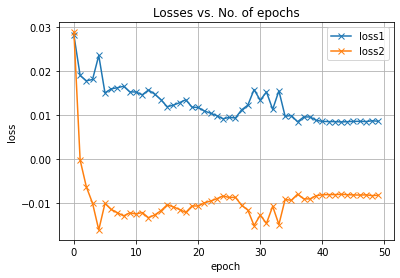

In [30]:
plot_history(history)

In [31]:
next(iter(train_loader))[0].shape

torch.Size([7919, 612])

In [32]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [33]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [34]:
results=testing(model,test_loader)

In [35]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_normal_test.shape[0]),
                       np.ones(windows_attack.shape[0])])

In [41]:
y_pred.shape

(697401,)

In [42]:
y_test.shape

(697401,)

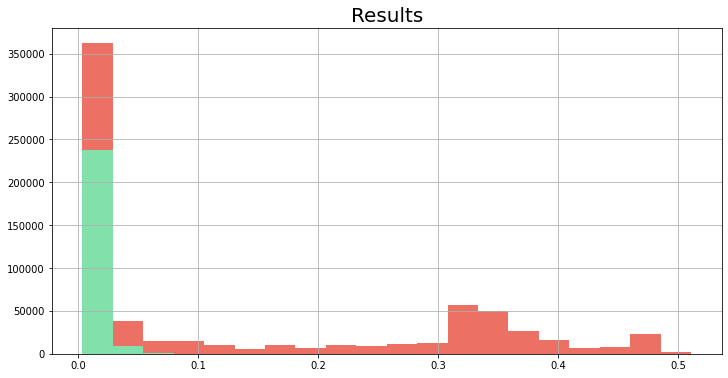

In [36]:
histogram(y_test,y_pred)

In [48]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

[1.5109748  0.51097476 0.4909061  ... 0.0039167  0.00391658 0.00351623]


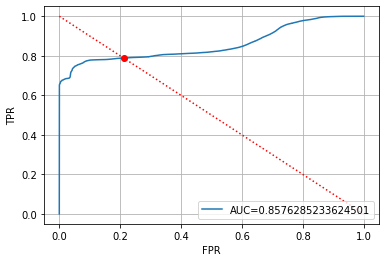

In [47]:
threshold=ROC(y_test,y_pred)

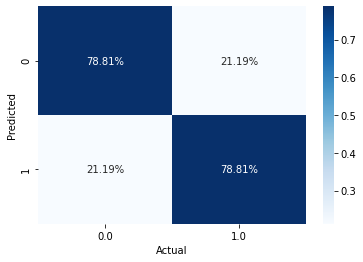

In [38]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)